# **09542026**

# **Purity Moraa Kinaro**

# **NLP Coding Assignment 2**

**Learning Objectives**
1. Develop a practical understanding of neural networks especially RNNs (and attention).
2. Be able to apply RNN to a relevant NLP problem following best practices.
3. Be able to train and evaluate a neural network for an NLP task.

**Question**

Develop an RNN to classify Amazon Fine Food Reviews into positive and negative. The dataset
is available here: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews. For the
purpose of this assignment, we will consider a review with a rating of 4 or 5 as positive and a
rating of 1 or 2 as negative. You are expected to train and evaluate your model following best
practices. Incorporate attention into your RNN and compare the results with RNN without
attention

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style so that we have better looking plots and visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
DATA_PATH = '/content/Reviews.csv'
df = pd.read_csv(DATA_PATH)
print("Loaded rows:", len(df))
df.head(2)

Loaded rows: 568454


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [3]:
print("DATASET OVERVIEW")

print(f"\nDataset shape: {df.shape}")
print(f"Total reviews: {len(df)}")
print(f"\nColumn names:\n{df.columns.tolist()}")

print(f"\nData types:\n{df.dtypes}")

DATASET OVERVIEW

Dataset shape: (568454, 10)
Total reviews: 568454

Column names:
['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

Data types:
Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object


From the above results, we have 10 columns. We have 568454 entries meaning that the total revies are 10. The columns in this dataset are Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
including the type of data they hold. some of them might not be useful for model training, in which I will drop them.

In [4]:
# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")


Missing values:
Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


We have 27 missing prifile names and 27 missing summaries in the data set

**Exploring the target variable**

In [5]:
print("RATING DISTRIBUTION")

# Count of each rating
rating_counts = df['Score'].value_counts().sort_index()
print(f"\nRating distribution:\n{rating_counts}")
print(f"\nPercentage distribution:\n{df['Score'].value_counts(normalize=True).sort_index() * 100}")


RATING DISTRIBUTION

Rating distribution:
Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: count, dtype: int64

Percentage distribution:
Score
1     9.194763
2     5.236835
3     7.501047
4    14.188483
5    63.878871
Name: proportion, dtype: float64


From the results above, Rating 5 has the highest count, accounting for 63.9% of the total, while Rating 2 has the lowest count, comprising 5.2% of the total. Rating 4 comes second after 5, then 1, then 3 and lastly 2.

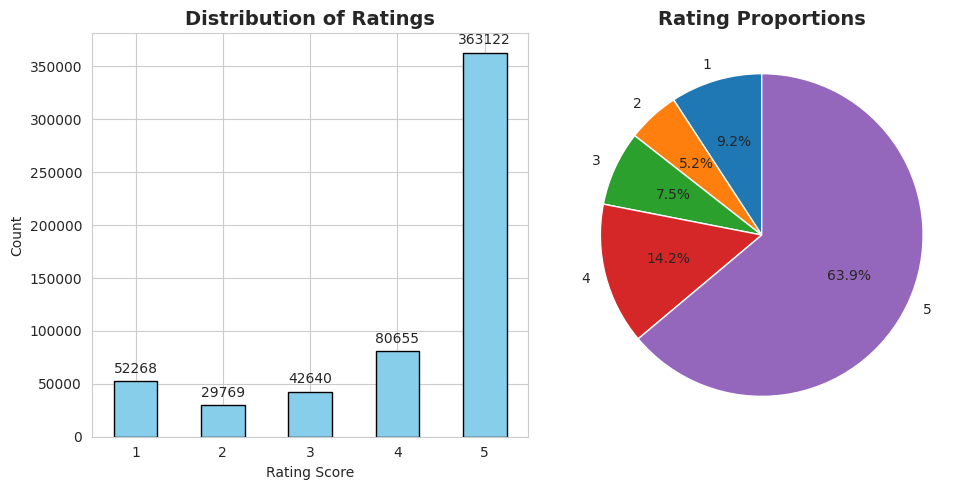

In [6]:
# Visualizing rating distribution in a pie chat and a hisogram
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
rating_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings', fontsize=14, fontweight='bold')
plt.xlabel('Rating Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(rating_counts):
    plt.text(i, v + 5000, str(v), ha='center', va='bottom')

plt.subplot(1, 2, 2)
rating_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Rating Proportions', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

**Exploring the text data**

In [7]:
print("TEXT DATA EXPLORATION")

# Calculating the text lengths
df['text_length'] = df['Text'].astype(str).apply(len)
df['summary_length'] = df['Summary'].astype(str).apply(len)

print(f"\nText length statistics:")
print(df['text_length'].describe())


TEXT DATA EXPLORATION

Text length statistics:
count    568454.000000
mean        436.222083
std         445.339741
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
Name: text_length, dtype: float64


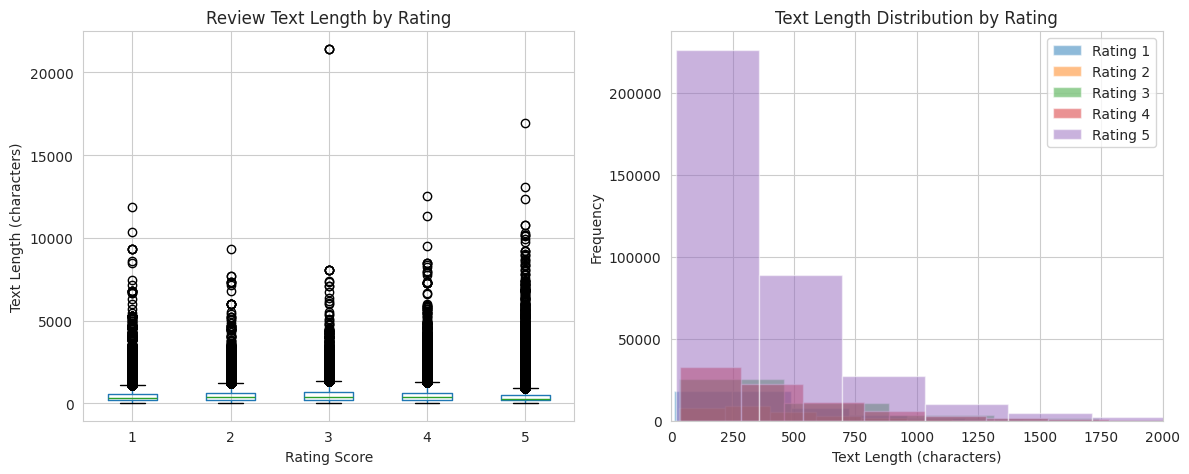

In [8]:
# Visualizing the text lengths by rating
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df.boxplot(column='text_length', by='Score', ax=plt.gca())
plt.title('Review Text Length by Rating')
plt.xlabel('Rating Score')
plt.ylabel('Text Length (characters)')
plt.suptitle('')  # Remove default title

plt.subplot(1, 2, 2)
for score in sorted(df['Score'].unique()):
    data = df[df['Score'] == score]['text_length']
    plt.hist(data, bins=50, alpha=0.5, label=f'Rating {score}')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution by Rating')
plt.legend()
plt.xlim(0, 2000)  # Focus on reasonable range
plt.tight_layout()
plt.show()

From the above visualizations, Rating 5 has the maximum text length with characters falling between 0 to around 17500. Also, characters with text length between 0 and 250 appear more than 200000 times in rating 5.

**Creating Binary labels**

First, I'll filter the dataset to remove rating three because we dont need it. We only need 1, 2, 4 and 5. Then I'll create a binary label where 0 represents 1 and 2 and 1 represents 4 and 5.

In [9]:
print("CREATING BINARY LABELS")

# to keep only ratings 1, 2, 4, 5 and exclude neutral rating 3
df_filtered = df[df['Score'].isin([1, 2, 4, 5])].copy()
print(f"\nRows after removing rating 3: {len(df_filtered)} (removed {len(df) - len(df_filtered)} rows)")

# creating a binary label where 0 = negative (1,2), 1 = positive (4,5)
df_filtered['label'] = df_filtered['Score'].apply(lambda x: 1 if x >= 4 else 0)

# Checking class distribution
label_counts = df_filtered['label'].value_counts()
print(f"\nClass distribution:")
print(f"Negative (0): {label_counts[0]} ({label_counts[0]/len(df_filtered)*100:.1f}%)")
print(f"Positive (1): {label_counts[1]} ({label_counts[1]/len(df_filtered)*100:.1f}%)")


CREATING BINARY LABELS

Rows after removing rating 3: 525814 (removed 42640 rows)

Class distribution:
Negative (0): 82037 (15.6%)
Positive (1): 443777 (84.4%)


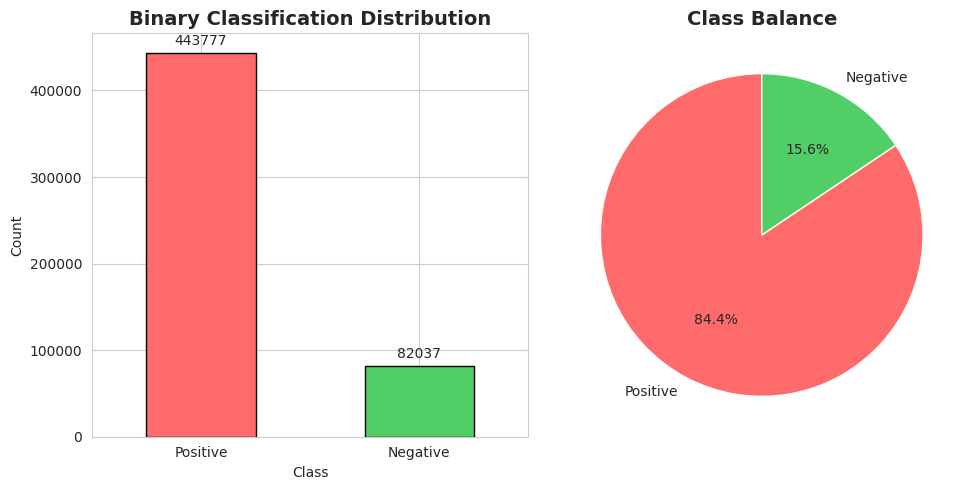

In [10]:
# Visualizing binary class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color=['#ff6b6b', '#51cf66'], edgecolor='black')
plt.title('Binary Classification Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Positive', 'Negative'], rotation=0)
for i, v in enumerate(label_counts):
    plt.text(i, v + 5000, str(v), ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(label_counts, labels=['Positive', 'Negative'], autopct='%1.1f%%',
        colors=['#ff6b6b', '#51cf66'], startangle=90)
plt.title('Class Balance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

From the distribution above, the negative class (rating 1 and 2) has the least count of 15.6% while the positive class has the highest count of 84.4%

**Sample Review from each class**

In [11]:
print("SAMPLE REVIEWS")
print("\nNEGATIVE REVIEWS (Label 0) ")
negative_samples = df_filtered[df_filtered['label'] == 0].sample(3, random_state=42)
for idx, row in negative_samples.iterrows():
    print(f"\nRating: {row['Score']}")
    print(f"Summary: {row['Summary']}")
    print(f"Text: {row['Text'][:200]}...")  # the first 200 characters

print("\n--- POSITIVE REVIEWS (Label 1) ---")
positive_samples = df_filtered[df_filtered['label'] == 1].sample(3, random_state=42)
for idx, row in positive_samples.iterrows():
    print(f"\nRating: {row['Score']}")
    print(f"Summary: {row['Summary']}")
    print(f"Text: {row['Text'][:200]}...")  # the first 200 characters


SAMPLE REVIEWS

NEGATIVE REVIEWS (Label 0) 

Rating: 2
Summary: Dim Chocolate
Text: I have an absolute passion for deep, dark hot chocolate. I want chocolate which tastes like *chocolate*, rich and flavorful, with a hint of a bite. You can savor chocolate like that.<br />What I have ...

Rating: 2
Summary: not the best
Text: This drink is so "super energy" it's almost frightening.  Several members of my family tasted it and the consensus was that it might, indeed, give you a boost but the taste...some even compared it to ...

Rating: 2
Summary: Yuck
Text: I'm sticking with what used to be carnation, now nestles malt. this stuff tastes like powdered milk with a hint of soy....

--- POSITIVE REVIEWS (Label 1) ---

Rating: 5
Summary: Classic by Gano
Text: I have started every morning for the last 7 months with a cup of Ganocafe Classic coffee. In my opinion it must be providing some benefits, I haven't had even one cold or any flu in that time. At age ...

Rating: 5
Summary: Appropriate f

**Checking for duplicates and missing text**

In [12]:
# Checking for duplicate reviews
duplicate_texts = df_filtered.duplicated(subset=['Text'], keep=False).sum()
print(f"\nDuplicate reviews (same text): {duplicate_texts}")

# Checking for missing text
missing_text = df_filtered['Text'].isnull().sum()
print(f"Missing review text: {missing_text}")


Duplicate reviews (same text): 215639
Missing review text: 0


We have no missing values but we have 215639 texts that are duplicate throughout the dataset.

**saving the processed data**

I have have opted to do away with some of the columns that the model will not use and keep the following columns: 'Text', 'Summary', 'Score', 'label'. After this, we save the new dataset into a new csv file. That's what we are going to use.

In [13]:
# Keeping only the necessary columns
df_processed = df_filtered[['Text', 'Summary', 'Score', 'label']].copy()
print(f"Shape: {df_processed.shape}")
print(f"Columns: {df_processed.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_processed.head())

# Saving to new CSV
df_processed.to_csv('processed_reviews.csv', index=False)
print("\nProcessed data saved to 'processed_reviews.csv'")



Shape: (525814, 4)
Columns: ['Text', 'Summary', 'Score', 'label']

First few rows:
                                                Text                Summary  \
0  I have bought several of the Vitality canned d...  Good Quality Dog Food   
1  Product arrived labeled as Jumbo Salted Peanut...      Not as Advertised   
2  This is a confection that has been around a fe...  "Delight" says it all   
3  If you are looking for the secret ingredient i...         Cough Medicine   
4  Great taffy at a great price.  There was a wid...            Great taffy   

   Score  label  
0      5      1  
1      1      0  
2      4      1  
3      2      0  
4      5      1  

Processed data saved to 'processed_reviews.csv'


**Cleaning the text**

Clean and preprocess text data
1. Converting to lowercase
2. Removing HTML tags
3. Removing special characters but keep basic punctuation
4. Removing extra whitespace


In [14]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter


def clean_text(text):

    # Convert to string in case of any non-string values
    text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Keep only letters, numbers, and basic punctuation
    text = re.sub(r'[^a-z0-9\s\.\,\!\?]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [15]:

df_processed['clean_text'] = df_processed['Text'].apply(clean_text)

# examples of cleaning
print("\nExample of text cleaning:")
for i in range(2):
    print(f"\nOriginal: {df_processed['Text'].iloc[i][:150]}...")
    print(f"Cleaned:  {df_processed['clean_text'].iloc[i][:150]}...")



Example of text cleaning:

Original: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than ...
Cleaned:  i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than ...

Original: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor inten...
Cleaned:  product arrived labeled as jumbo salted peanuts...the peanuts were actually small sized unsalted. not sure if this was an error or if the vendor inten...


**Splitting the data into Train, Validation and Test set**

In [16]:

# First, let's handle class imbalance by sampling
# Balance the dataset to prevent bias towards positive class
min_class_count = df_processed['label'].value_counts().min()
print(f"\nOriginal class distribution:")
print(df_processed['label'].value_counts())

# Undersample majority class
df_negative = df_processed[df_processed['label'] == 0]
df_positive = df_processed[df_processed['label'] == 1].sample(n=len(df_negative), random_state=42)
df_balanced = pd.concat([df_negative, df_positive]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nBalanced class distribution:")
print(df_balanced['label'].value_counts())
print(f"Total samples: {len(df_balanced)}")

# Split: 70% train, 15% validation, 15% test
X = df_balanced['clean_text'].values
y = df_balanced['label'].values

# the first split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# the second split 15% validation, 15% test (split the 30% temp equally)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nData split:")
print(f"Training set:   {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set:       {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")



Original class distribution:
label
1    443777
0     82037
Name: count, dtype: int64

Balanced class distribution:
label
0    82037
1    82037
Name: count, dtype: int64
Total samples: 164074

Data split:
Training set:   114851 samples (70.0%)
Validation set: 24611 samples (15.0%)
Test set:       24612 samples (15.0%)


I split the data into three sets: 70% for training (teaching the model), 15% for validation (tuning the model during training), and 15% for testing (final evaluation). I used stratification to make sure each set has an equal balance of positive and negative reviews. That's why we can see from the above result we have the following:

Data split:
Training set:   114851 samples (70.0%)
Validation set: 24611 samples (15.0%)
Test set:       24612 samples (15.0%)

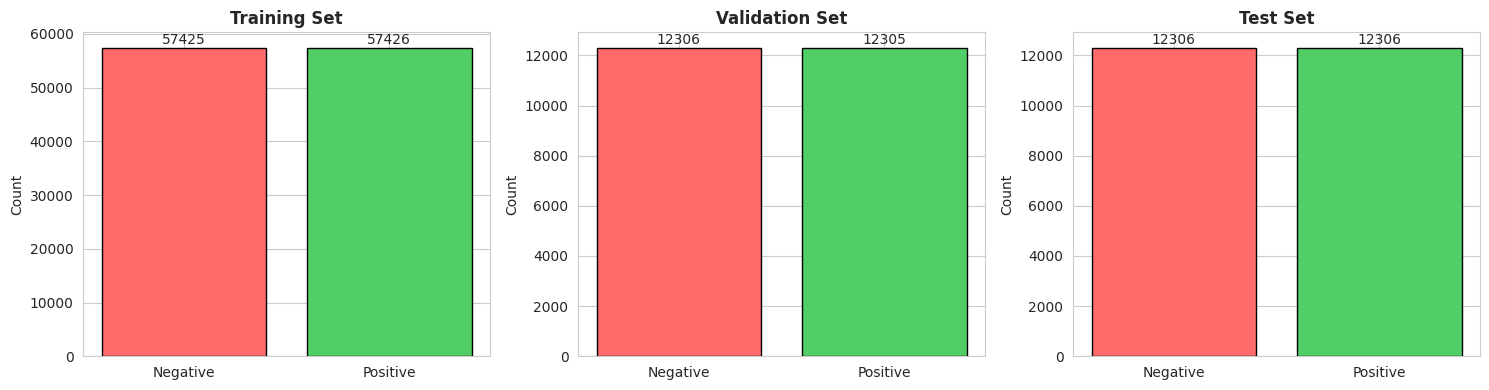

In [17]:
# Visualizing the splitted dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
datasets = [y_train, y_val, y_test]
titles = ['Training Set', 'Validation Set', 'Test Set']

for ax, data, title in zip(axes, datasets, titles):
    unique, counts = np.unique(data, return_counts=True)
    ax.bar(['Negative', 'Positive'], counts, color=['#ff6b6b', '#51cf66'], edgecolor='black')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Count')
    for i, v in enumerate(counts):
        ax.text(i, v + 50, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


**Building the Vocabulary**

In [18]:
print("BUILDING VOCABULARY")

def build_vocabulary(texts, max_vocab_size=10000):
    """
    Build vocabulary from texts
    Returns word_to_idx mapping
    """
    # Tokenize and count words
    word_counts = Counter()
    for text in texts:
        words = text.split()
        word_counts.update(words)

    # Get most common words
    most_common = word_counts.most_common(max_vocab_size - 2)  # -2 for PAD and UNK

    # Create word to index mapping
    # 0 = PAD (padding), 1 = UNK (unknown)
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for idx, (word, count) in enumerate(most_common, start=2):
        word_to_idx[word] = idx

    return word_to_idx, word_counts

# building the vocabulary from the training data only
word_to_idx, word_counts = build_vocabulary(X_train, max_vocab_size=10000)

print(f"\nVocabulary size: {len(word_to_idx)}")
print(f"Total unique words in training data: {len(word_counts)}")
print(f"Coverage: {len(word_to_idx)/len(word_counts)*100:.1f}%")

#the most common words
print("\nTop 20 most common words:")
for word, count in word_counts.most_common(20):
    print(f"  {word}: {count}")

BUILDING VOCABULARY

Vocabulary size: 10000
Total unique words in training data: 183727
Coverage: 5.4%

Top 20 most common words:
  the: 395118
  i: 309411
  and: 252685
  a: 231705
  to: 209817
  of: 168212
  it: 161428
  is: 140945
  this: 135764
  in: 109435
  for: 104504
  that: 89136
  my: 88516
  not: 79361
  was: 78793
  but: 75750
  have: 68601
  with: 68175
  they: 59916
  you: 59772


I built a vocabulary of the 10,000 most common words from the training data. Words that aren't in this list will be marked as "unknown". I'm using the training data only to build the vocabulary to avoid data leakage.

**Converting text to sequence**

I will convert each review into a sequence of numbers, where each number represents a word from my vocabulary. For example, the word "good" might be represented by the number 45. This is how I make text understandable to the neural network.

In [19]:

print("CONVERTING TEXT TO SEQUENCES")


def text_to_sequence(text, word_to_idx):
    """
    Convert text to sequence of indices
    """
    words = text.split()
    sequence = [word_to_idx.get(word, 1) for word in words]  # 1 = UNK
    return sequence

# Convert all texts to sequences
X_train_seq = [text_to_sequence(text, word_to_idx) for text in X_train]
X_val_seq = [text_to_sequence(text, word_to_idx) for text in X_val]
X_test_seq = [text_to_sequence(text, word_to_idx) for text in X_test]

# Check sequence lengths
train_lengths = [len(seq) for seq in X_train_seq]
print(f"\nSequence length statistics (training set):")
print(f"  Mean: {np.mean(train_lengths):.1f}")
print(f"  Median: {np.median(train_lengths):.1f}")
print(f"  Min: {np.min(train_lengths)}")
print(f"  Max: {np.max(train_lengths)}")
print(f"  95th percentile: {np.percentile(train_lengths, 95):.1f}")


CONVERTING TEXT TO SEQUENCES

Sequence length statistics (training set):
  Mean: 81.0
  Median: 58.0
  Min: 3
  Max: 2385
  95th percentile: 215.0


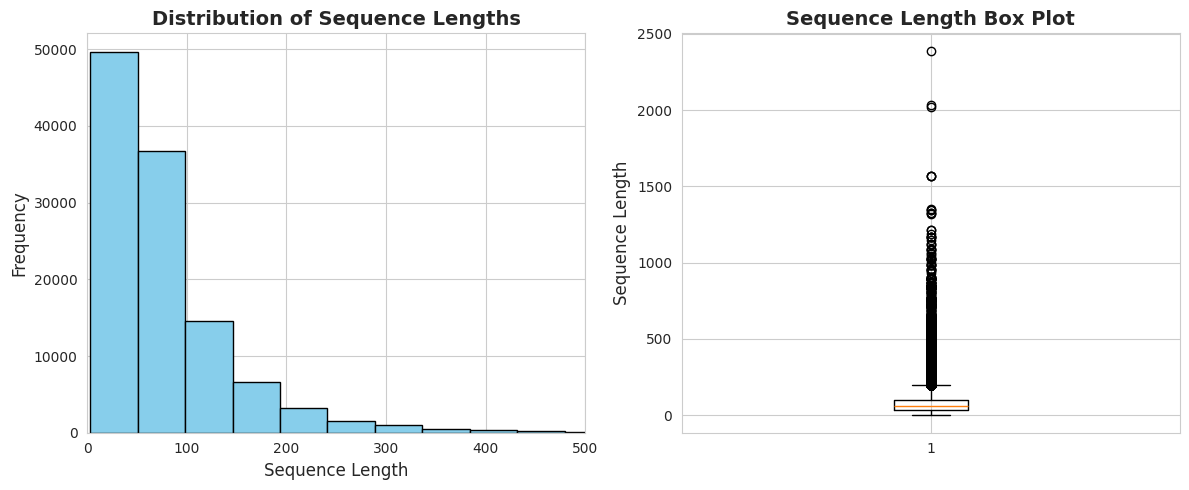

In [20]:
# Visualizing the sequence lengths
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Sequence Lengths', fontsize=14, fontweight='bold')
plt.xlim(0, 500)  # to focus on reasonable range

plt.subplot(1, 2, 2)
plt.boxplot(train_lengths, vert=True)
plt.ylabel('Sequence Length', fontsize=12)
plt.title('Sequence Length Box Plot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


**Pad Sequence**

To set all sequences to the same length, which in this case is 200 words. If a review is shorter, I add padding. If it's longer, I cut it off. This is necessary because neural networks need consistent input sizes. I chose 200 based on the 95th percentile of review lengths.

In [21]:
print("PADDING SEQUENCES")

def pad_sequences(sequences, max_length=200, padding_value=0):
    """
    Pad sequences to the same length
    Truncate if longer, pad with 0s if shorter
    """
    padded = np.zeros((len(sequences), max_length), dtype=np.int32)

    for i, seq in enumerate(sequences):
        seq_len = min(len(seq), max_length)
        padded[i, :seq_len] = seq[:seq_len]

    return padded

# Choosing the maximumlength based on 95th percentile
MAX_LENGTH = 200

X_train_padded = pad_sequences(X_train_seq, max_length=MAX_LENGTH)
X_val_padded = pad_sequences(X_val_seq, max_length=MAX_LENGTH)
X_test_padded = pad_sequences(X_test_seq, max_length=MAX_LENGTH)

print(f"Max sequence length set to: {MAX_LENGTH}")
print(f"\nPadded shapes:")
print(f"  X_train: {X_train_padded.shape}")
print(f"  X_val:   {X_val_padded.shape}")
print(f"  X_test:  {X_test_padded.shape}")


print("\nExample of sequence padding:")
print(f"Original text: {X_train[0][:100]}...")
print(f"Original sequence length: {len(X_train_seq[0])}")
print(f"First 20 indices: {X_train_seq[0][:20]}")
print(f"Padded shape: {X_train_padded[0].shape}")
print(f"First 20 padded: {X_train_padded[0][:20]}")


PADDING SEQUENCES
Max sequence length set to: 200

Padded shapes:
  X_train: (114851, 200)
  X_val:   (24611, 200)
  X_test:  (24612, 200)

Example of sequence padding:
Original text: i love tea. it is important for me to have a good quality, strong tea. this is the winner! i got 6 p...
Original sequence length: 36
First 20 indices: [3, 62, 318, 8, 9, 1242, 12, 61, 6, 18, 5, 43, 1714, 265, 318, 10, 9, 2, 1, 3]
Padded shape: (200,)
First 20 padded: [   3   62  318    8    9 1242   12   61    6   18    5   43 1714  265
  318   10    9    2    1    3]


**summary and saving**

In [22]:

print(f"Training samples: {len(X_train_padded)}")
print(f"Validation samples: {len(X_val_padded)}")
print(f"Test samples: {len(X_test_padded)}")
print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Sequence length: {MAX_LENGTH}")




Training samples: 114851
Validation samples: 24611
Test samples: 24612
Vocabulary size: 10000
Sequence length: 200


**Building the RNN without Attention**

My RNN model has three main parts:

Embedding layer: Converts word numbers into dense vectors that capture meaning
LSTM layer: A type of RNN that processes the sequence and remembers important information (I'm using 2 layers with 128 hidden units)
Fully connected layers: Takes the LSTM output and makes the final prediction (positive or negative)*

I chose LSTM  instead of a simple RNN because LSTMs are better at remembering long-term dependencies in text.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#
np.random.seed(42)
torch.manual_seed(42)

# to check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


**Preparing the data for pytorch**

In [24]:


# Converting the numpy arrays to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train_padded)
y_train_tensor = torch.FloatTensor(y_train)

X_val_tensor = torch.LongTensor(X_val_padded)
y_val_tensor = torch.FloatTensor(y_val)

X_test_tensor = torch.LongTensor(X_test_padded)
y_test_tensor = torch.FloatTensor(y_test)

print(f"Training data shape: {X_train_tensor.shape}")
print(f"Training labels shape: {y_train_tensor.shape}")


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


Training data shape: torch.Size([114851, 200])
Training labels shape: torch.Size([114851])

Batch size: 64
Number of training batches: 1795
Number of validation batches: 385


**Defining RNN model**



In [25]:
print("BUILDING RNN MODEL")

class RNN(nn.Module):


    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(RNN, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim,      # Input size
            hidden_dim,         # Hidden state size
            n_layers,           # Number of LSTM layers
            batch_first=True,   # Input shape: (batch, seq_len, features)
            dropout=dropout if n_layers > 1 else 0,  # Dropout between layers
            bidirectional=False # Use False for simple RNN
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Activation
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, seq_len)

        # Embedding: (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(x)

        # LSTM: output shape: (batch_size, seq_len, hidden_dim)
        # We only need the last hidden state
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Take the last hidden state: (batch_size, hidden_dim)
        last_hidden = hidden[-1]  # If n_layers > 1, take the last layer

        # Fully connected layers
        x = self.dropout(last_hidden)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))

        return x.squeeze()  # Output shape: (batch_size,)


BUILDING RNN MODEL


In [26]:
# Model hyperparameters
VOCAB_SIZE = len(word_to_idx)
EMBEDDING_DIM = 100  # Size of word embeddings
HIDDEN_DIM = 128     # Size of LSTM hidden state
OUTPUT_DIM = 1       # Binary classification
N_LAYERS = 2         # Number of LSTM layers
DROPOUT = 0.3        # Dropout rate

# Creating the model
model = RNN(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
)

# Moving the model to device (GPU/CPU)
model = model.to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel architecture:")
print(model)
print(f"\nTotal trainable parameters: {count_parameters(model):,}")



Model architecture:
RNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total trainable parameters: 1,258,177


**Defining loss and optimizer**

In [27]:
# Loss function (Binary Cross Entropy)
criterion = nn.BCELoss()

# Optimizer (Adam)
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Loss function: Binary Cross Entropy")
print(f"Optimizer: Adam")
print(f"Learning rate: {LEARNING_RATE}")


Loss function: Binary Cross Entropy
Optimizer: Adam
Learning rate: 0.001


**Training Functions**



In [28]:
def train_epoch(model, loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch_x, batch_y in loader:
        # Move to device
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(batch_x)

        # Calculate loss
        loss = criterion(predictions, batch_y)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy
        rounded_preds = torch.round(predictions)
        correct = (rounded_preds == batch_y).float()
        acc = correct.sum() / len(correct)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)


In [29]:
def evaluate(model, loader, criterion, device):
    """Evaluating the model"""
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():  # with no gradient computation
        for batch_x, batch_y in loader:
            # Moving it to the device
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            # Forward pass
            predictions = model(batch_x)

            # Calculate loss
            loss = criterion(predictions, batch_y)

            # Calculating the accuracy
            rounded_preds = torch.round(predictions)
            correct = (rounded_preds == batch_y).float()
            acc = correct.sum() / len(correct)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)


**Training the model**

I'm training for 10 epochs (10 complete passes through the training data). For each epoch, I train on the training set and then check performance on the validation set. I'm saving the model with the best validation loss to prevent overfitting.

In [30]:
print("TRAINING MODEL")


N_EPOCHS = 10

# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_loss = float('inf')

print(f"\nTraining for {N_EPOCHS} epochs...\n")

for epoch in range(N_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

    # Evaluate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
    print()

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_rnn_model.pt')
        print(" The model has been saved successfully")
        print()

print("Training is complete")


TRAINING MODEL

Training for 10 epochs...

Epoch 1/10
  Train Loss: 0.6920 | Train Acc: 50.74%
  Val Loss:   0.6913 | Val Acc:   50.83%

 The model has been saved successfully

Epoch 2/10
  Train Loss: 0.6865 | Train Acc: 51.98%
  Val Loss:   0.6734 | Val Acc:   56.19%

 The model has been saved successfully

Epoch 3/10
  Train Loss: 0.6732 | Train Acc: 56.20%
  Val Loss:   0.6706 | Val Acc:   56.78%

 The model has been saved successfully

Epoch 4/10
  Train Loss: 0.6714 | Train Acc: 54.66%
  Val Loss:   0.6829 | Val Acc:   52.40%

Epoch 5/10
  Train Loss: 0.6469 | Train Acc: 58.40%
  Val Loss:   0.5075 | Val Acc:   78.26%

 The model has been saved successfully

Epoch 6/10
  Train Loss: 0.3476 | Train Acc: 85.76%
  Val Loss:   0.2645 | Val Acc:   89.31%

 The model has been saved successfully

Epoch 7/10
  Train Loss: 0.2182 | Train Acc: 91.71%
  Val Loss:   0.2211 | Val Acc:   91.62%

 The model has been saved successfully

Epoch 8/10
  Train Loss: 0.1633 | Train Acc: 94.02%
  Val L

We have trained the model with 10 epochs. The model keeps on reducing its train and validation loss and increasing its train and validation accuracy as we go to the next epoch. At the 10th epoch, we have a model who's train and validation loss are 0.0933 and 0.2195 respectively and train and validation accuracy of 96.85% and 92.44% respectively.

**A plot of the training history**

VISUALIZING TRAINING HISTORY


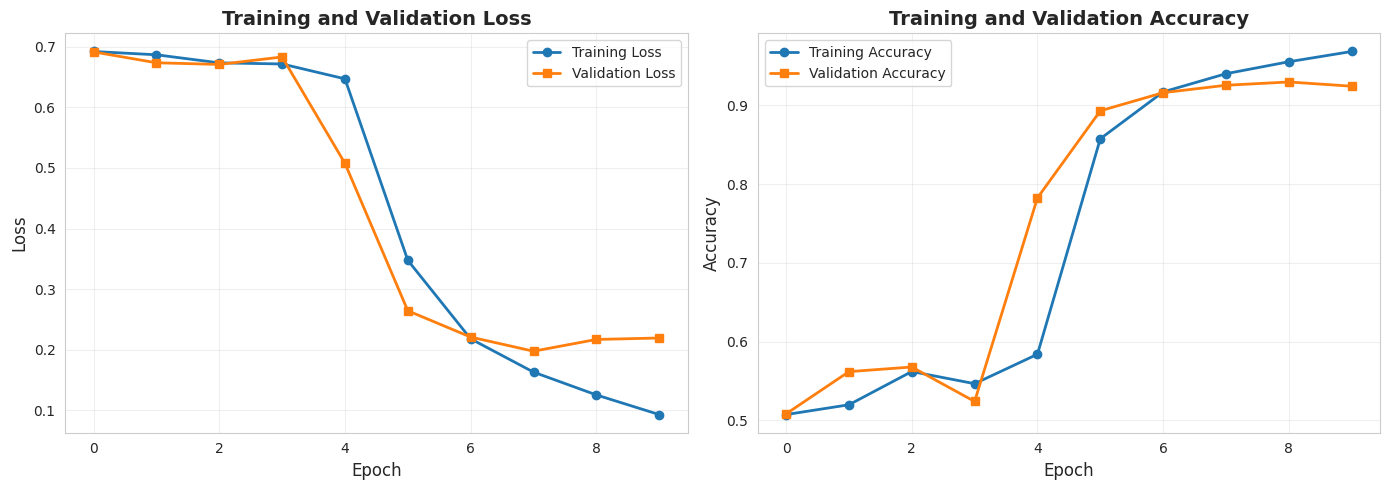

In [31]:
print("VISUALIZING TRAINING HISTORY")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# A plot of the loss
axes[0].plot(train_losses, label='Training Loss', marker='o', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# a plot of the accuracy
axes[1].plot(train_accs, label='Training Accuracy', marker='o', linewidth=2)
axes[1].plot(val_accs, label='Validation Accuracy', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Evaluating the model on the test set**

In [32]:
print("EVALUATING ON TEST SET")

# Loading the best model
model.load_state_dict(torch.load('best_rnn_model.pt'))

# getting the predictions on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        predictions = model(batch_x)
        rounded_preds = torch.round(predictions)

        all_preds.extend(rounded_preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# calculating the metrics
test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds)
test_recall = recall_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds)

print(f"\nTest Set Results:")
print(f"  Accuracy:  {test_acc*100:.2f}%")
print(f"  Precision: {test_precision*100:.2f}%")
print(f"  Recall:    {test_recall*100:.2f}%")
print(f"  F1-Score:  {test_f1*100:.2f}%")


EVALUATING ON TEST SET

Test Set Results:
  Accuracy:  92.03%
  Precision: 91.80%
  Recall:    92.30%
  F1-Score:  92.05%


Ater evaluating the model on the test set, we have a model we have the following perfomance of the model:
Accuracy:  92.03%
  Precision: 91.80%
  Recall:    92.30%
  F1-Score:  92.05%
which is quite a good perfoming model.

**Confussion Matrix**

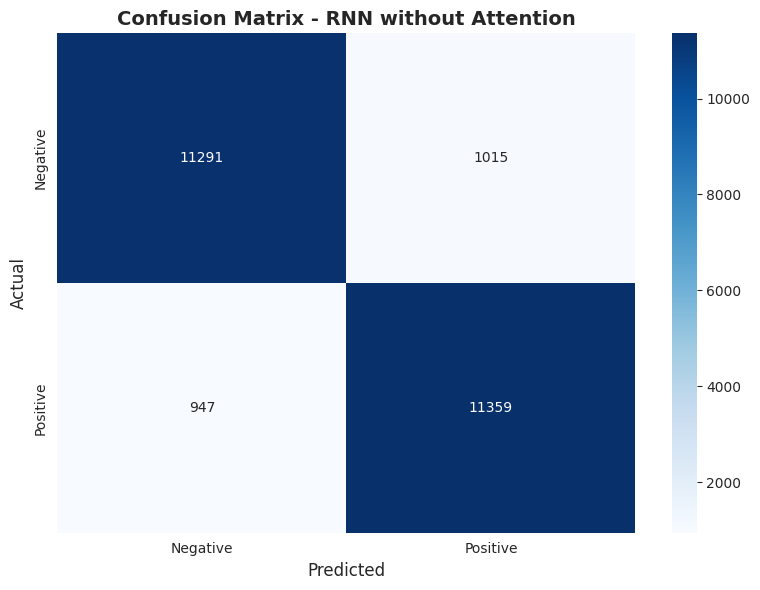

In [33]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - RNN without Attention', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [34]:
import torch.nn.functional as F

**Defining the Attention Mechanism**

Attention mechanism: It takes LSTM outputs and computes attention weights, then it returns weighted sum of LSTM outputs which now is the context vector

In [35]:
print("BUILDING RNN WITH ATTENTION")

class Attention(nn.Module):

    def __init__(self, hidden_dim):
        super(Attention, self).__init__()

        # This is the linear layer to compute attention scores
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_outputs):
        # lstm_outputs shape: (batch_size, seq_len, hidden_dim)

        # Calculate attention scores for each time step
        # Shape: (batch_size, seq_len, 1)
        attention_scores = self.attention(lstm_outputs)

        # Applying softmax to get attention weights
        # Shape: (batch_size, seq_len, 1)
        attention_weights = F.softmax(attention_scores, dim=1)

        # Multiplying the LSTM outputs by attention weights and sum
        # Shape: (batch_size, hidden_dim)
        context_vector = torch.sum(attention_weights * lstm_outputs, dim=1)

        return context_vector, attention_weights


BUILDING RNN WITH ATTENTION


**RNN with Attention**

RNN with Attention
The embedding layer converts word indices to dense vectors
The LSTM layer processes the sequence
The attention layer - focuses on important words
And now we have a fully connected layers which we will use for classification

In [36]:
class RNNWithAttention(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(RNNWithAttention, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
            bidirectional=False
        )

        # Attention layer
        self.attention = Attention(hidden_dim)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Activation
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, seq_len)

        # Embedding: (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(x)

        # LSTM: (batch_size, seq_len, hidden_dim)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Apply attention to get context vector
        # context_vector shape: (batch_size, hidden_dim)
        # attention_weights shape: (batch_size, seq_len, 1)
        context_vector, attention_weights = self.attention(lstm_out)

        # Fully connected layers
        x = self.dropout(context_vector)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))

        return x.squeeze(), attention_weights  # to return predictions and attention weights


In [37]:
#the model hyperparameters, which is the same as baseline
VOCAB_SIZE = len(word_to_idx)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.3

# creating the model with attention
model_attention = RNNWithAttention(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
)

#moving the model to the device
model_attention = model_attention.to(device)

#count of the parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel architecture:")
print(model_attention)
print(f"\nTotal trainable parameters: {count_parameters(model_attention):,}")



Model architecture:
RNNWithAttention(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3)
  (attention): Attention(
    (attention): Linear(in_features=128, out_features=1, bias=True)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total trainable parameters: 1,258,306


**Reusing the same data loaders**

In [38]:
print("PREPARING DATA")


#converting to tensors
X_train_tensor = torch.LongTensor(X_train_padded)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.LongTensor(X_val_padded)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.LongTensor(X_test_padded)
y_test_tensor = torch.FloatTensor(y_test)

#creating the datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

#creating the data loaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

PREPARING DATA
Training batches: 1795
Validation batches: 385
Test batches: 385


**Training the functions that have been modified for attention**

In [39]:
def train_epoch_attention(model, loader, optimizer, criterion, device):
    """Train for one epoch with attention model"""
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch_x, batch_y in loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        # Forward pass. The model returns predictions and attention weight
        predictions, _ = model(batch_x)

        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

        #to calculate accuracy
        rounded_preds = torch.round(predictions)
        correct = (rounded_preds == batch_y).float()
        acc = correct.sum() / len(correct)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

def evaluate_attention(model, loader, criterion, device):
    """Evaluating the attention model"""
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions, _ = model(batch_x)

            loss = criterion(predictions, batch_y)

            rounded_preds = torch.round(predictions)
            correct = (rounded_preds == batch_y).float()
            acc = correct.sum() / len(correct)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)


**Training the model with Attention**

In [40]:
print("TRAINING MODEL WITH ATTENTION")


# Loss and optimizer
criterion = nn.BCELoss()
LEARNING_RATE = 0.001
optimizer = optim.Adam(model_attention.parameters(), lr=LEARNING_RATE)

N_EPOCHS = 10

#we will use lists to store metrics
train_losses_att = []
train_accs_att = []
val_losses_att = []
val_accs_att = []

best_val_loss = float('inf')

print(f"\nTraining for {N_EPOCHS} epochs...\n")

for epoch in range(N_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch_attention(model_attention, train_loader, optimizer, criterion, device)

    # Evaluate
    val_loss, val_acc = evaluate_attention(model_attention, val_loader, criterion, device)

    # Store metrics
    train_losses_att.append(train_loss)
    train_accs_att.append(train_acc)
    val_losses_att.append(val_loss)
    val_accs_att.append(val_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
    print()

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_attention.state_dict(), 'best_rnn_attention_model.pt')
        print("The model has been saved!")
        print()

print("Training is complete")


TRAINING MODEL WITH ATTENTION

Training for 10 epochs...

Epoch 1/10
  Train Loss: 0.3338 | Train Acc: 85.05%
  Val Loss:   0.2240 | Val Acc:   91.05%

The model has been saved!

Epoch 2/10
  Train Loss: 0.1881 | Train Acc: 92.85%
  Val Loss:   0.1911 | Val Acc:   92.57%

The model has been saved!

Epoch 3/10
  Train Loss: 0.1408 | Train Acc: 94.79%
  Val Loss:   0.1845 | Val Acc:   93.11%

The model has been saved!

Epoch 4/10
  Train Loss: 0.1047 | Train Acc: 96.34%
  Val Loss:   0.1834 | Val Acc:   93.54%

The model has been saved!

Epoch 5/10
  Train Loss: 0.0728 | Train Acc: 97.51%
  Val Loss:   0.2045 | Val Acc:   93.42%

Epoch 6/10
  Train Loss: 0.0501 | Train Acc: 98.34%
  Val Loss:   0.2361 | Val Acc:   93.39%

Epoch 7/10
  Train Loss: 0.0364 | Train Acc: 98.85%
  Val Loss:   0.2575 | Val Acc:   93.37%

Epoch 8/10
  Train Loss: 0.0275 | Train Acc: 99.10%
  Val Loss:   0.4107 | Val Acc:   92.80%

Epoch 9/10
  Train Loss: 0.0227 | Train Acc: 99.28%
  Val Loss:   0.3274 | Val Acc

When taining the RNN model with attention, the loss has reduced significantly. We also have a better accuracy at the last epoch.

**Evaluating on the test set**

In [41]:
print("EVALUATING THE MODEL ON THE TEST SET")

# Loading the best model
model_attention.load_state_dict(torch.load('best_rnn_attention_model.pt'))

#getting predictions on test set
model_attention.eval()
all_preds_att = []
all_labels_att = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        predictions, _ = model_attention(batch_x)
        rounded_preds = torch.round(predictions)

        all_preds_att.extend(rounded_preds.cpu().numpy())
        all_labels_att.extend(batch_y.numpy())

all_preds_att = np.array(all_preds_att)
all_labels_att = np.array(all_labels_att)

#calculating the metrics
test_acc_att = accuracy_score(all_labels_att, all_preds_att)
test_precision_att = precision_score(all_labels_att, all_preds_att)
test_recall_att = recall_score(all_labels_att, all_preds_att)
test_f1_att = f1_score(all_labels_att, all_preds_att)

print(f"\nThe test Set Results of RNN with Attention are:")
print(f"  Accuracy:  {test_acc_att*100:.2f}%")
print(f"  Precision: {test_precision_att*100:.2f}%")
print(f"  Recall:    {test_recall_att*100:.2f}%")
print(f"  F1-Score:  {test_f1_att*100:.2f}%")

EVALUATING THE MODEL ON THE TEST SET

The test Set Results of RNN with Attention are:
  Accuracy:  93.06%
  Precision: 93.92%
  Recall:    92.07%
  F1-Score:  92.99%


we have a slightly better perfomace of this model with attention compared to the earlier one without attention.

These are the comparison.
1. RNN model without attention:

  Accuracy:  92.03%

  Precision: 91.80%

  Recall:    92.30%

  F1-Score:  92.05%

2. With the attention Mechanism:

  Accuracy:  93.06%

  Precision: 93.92%

  Recall:    92.07%

  F1-Score:  92.99%

Clearly, from evaluating the models' perfomances it is clear that the one with attention mechanism performs better compared to the one without attention.


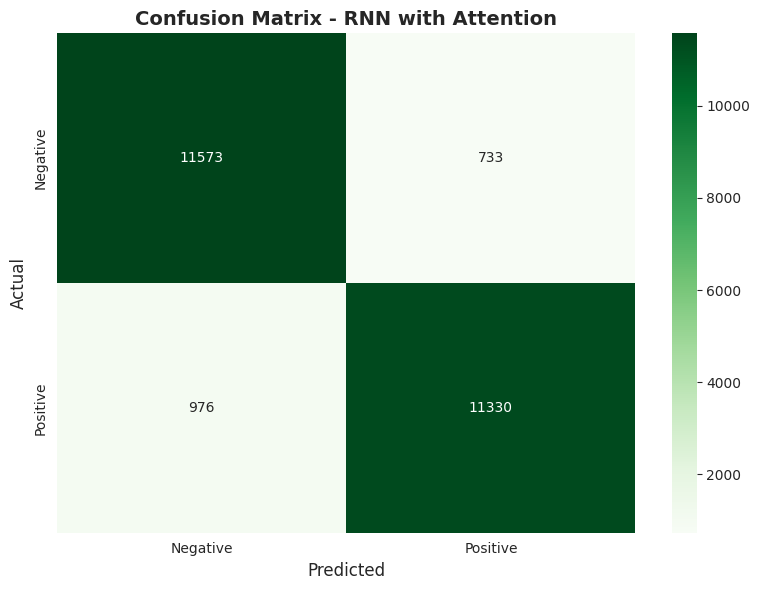

In [42]:
# Confusion matrix
cm_att = confusion_matrix(all_labels_att, all_preds_att)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_att, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - RNN with Attention', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Comparing the models**



In [43]:
# Plot loss comparison
axes[0].plot(train_losses_att, label='Train Loss (Attention)', marker='o', linewidth=2)
axes[0].plot(val_losses_att, label='Val Loss (Attention)', marker='s', linewidth=2)
# If you have baseline losses, add: axes[0].plot(train_losses, '--', label='Train Loss (Baseline)')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plotting accuracy comparison
axes[1].plot(train_accs_att, label='Train Acc (Attention)', marker='o', linewidth=2)
axes[1].plot(val_accs_att, label='Val Acc (Attention)', marker='s', linewidth=2)

axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

**Visualizing Attention Weights**

In [44]:

print("VISUALIZING ATTENTION WEIGHTS")

def visualize_attention(model, text_seq, true_label, word_to_idx, idx_to_word):
    """
    Visualizing attention weights
    """
    model.eval()

    # Converting to tensor
    text_tensor = torch.LongTensor(text_seq).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction, attention_weights = model(text_tensor)

    #getting attention weights and removing the batch dimension
    attention = attention_weights.squeeze().cpu().numpy()

    #converting indices back to words
    words = [idx_to_word.get(idx, '<UNK>') for idx in text_seq if idx != 0]  # Skip padding

    #trimming the attention weights to match non-padded length
    attention = attention[:len(words)]

    # Creating visualization
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(words)), attention, color='skyblue', edgecolor='black')
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    plt.xlabel('Words', fontsize=12)
    plt.ylabel('Attention Weight', fontsize=12)
    plt.title(f'Attention Weights | Prediction: {"Positive" if prediction > 0.5 else "Negative"} ({prediction.item():.3f}) | True: {"Positive" if true_label == 1 else "Negative"}',
              fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


    word_attention = list(zip(words, attention))
    word_attention.sort(key=lambda x: x[1], reverse=True)

    print("\nTop 10 most attended words:")
    for word, weight in word_attention[:10]:
        print(f"  {word}: {weight:.4f}")


VISUALIZING ATTENTION WEIGHTS



Visualizing attention for sample review

 Example 1: Positive Review 


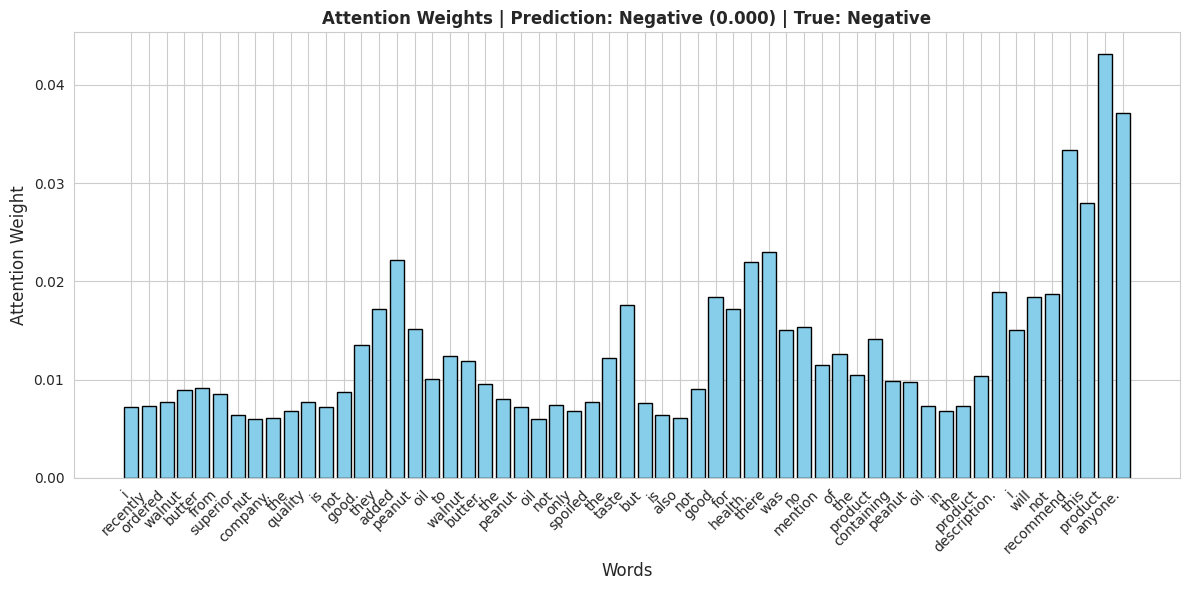


Top 10 most attended words:
  product: 0.0432
  anyone.: 0.0372
  recommend: 0.0334
  this: 0.0280
  there: 0.0230
  added: 0.0222
  health.: 0.0220
  description.: 0.0189
  not: 0.0188
  good: 0.0184

Example 2: Negative Review


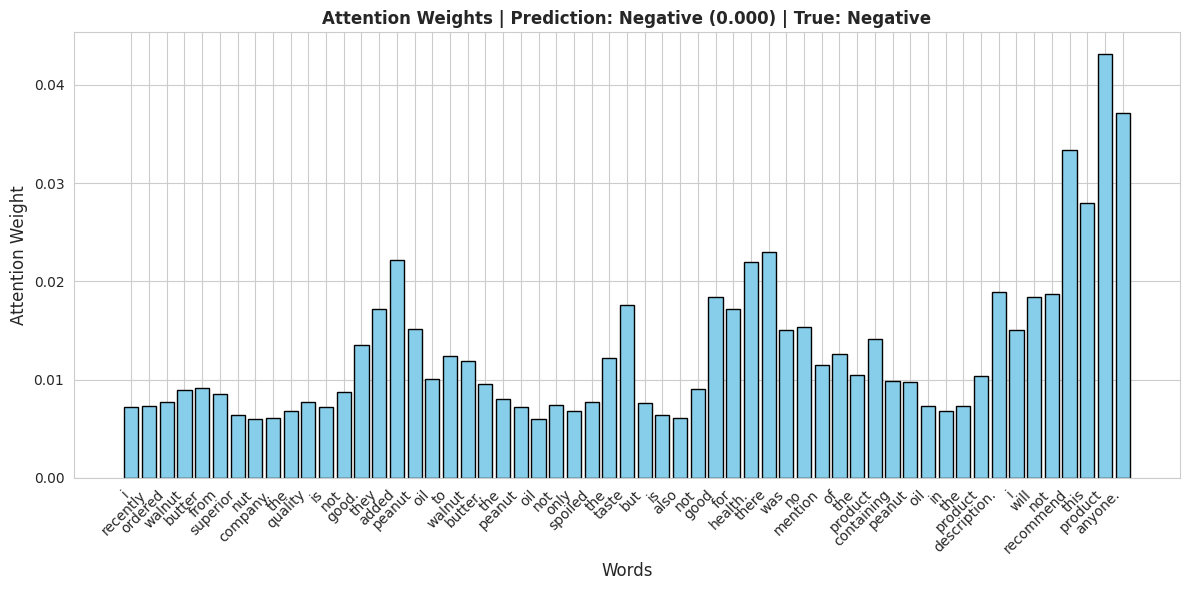


Top 10 most attended words:
  product: 0.0432
  anyone.: 0.0372
  recommend: 0.0334
  this: 0.0280
  there: 0.0230
  added: 0.0222
  health.: 0.0220
  description.: 0.0189
  not: 0.0188
  good: 0.0184


In [45]:
#creatingthe reverse mapping (index to word)
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Visualize attention for a few examples
print("\nVisualizing attention for sample review")
print("\n Example 1: Positive Review ")
visualize_attention(model_attention, X_test_padded[0], y_test[0], word_to_idx, idx_to_word)

print("\nExample 2: Negative Review")
# Find a negative example
neg_idx = np.where(y_test == 0)[0][0]
visualize_attention(model_attention, X_test_padded[neg_idx], y_test[neg_idx], word_to_idx, idx_to_word)

